## Intro to statsmodels

In [1]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('../Data/macrodata.csv',index_col=0 , parse_dates = True)

In [8]:
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


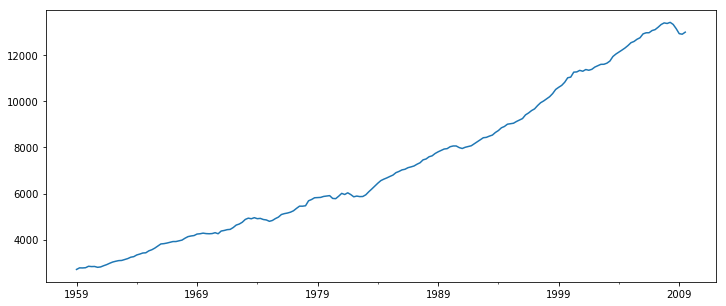

In [13]:
df['realgdp'].plot(figsize = (12,5))

## Using Statsmodels to get the trend
<div class="alert alert-info"><h3>Related Function:</h3>
<tt><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html'><strong>statsmodels.tsa.filters.hp_filter.hpfilter</strong></a><font color=black>(X, lamb=1600)</font>&nbsp;&nbsp;Hodrick-Prescott filter</div>
    
The <a href='https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter'>Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

The components are determined by minimizing the following quadratic loss function, where $\lambda$ is a smoothing parameter:

$\min_{\\{ \tau_{t}\\} }\sum_{t=1}^{T}c_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$


The $\lambda$ value above handles variations in the growth rate of the trend component.<br>When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [10]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [11]:
#breakdown into cycle and trend component (quartly data use 1600)
gdp_cycle, gdp_trend = hpfilter(df['realgdp'],lamb = 1600)

In [12]:
type(gdp_trend)

pandas.core.series.Series

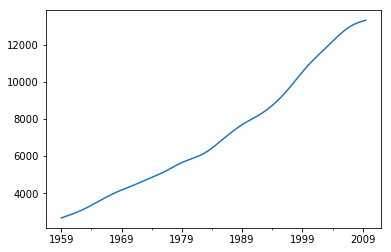

In [15]:
gdp_trend.plot()

In [17]:
df['trend'] = gdp_trend

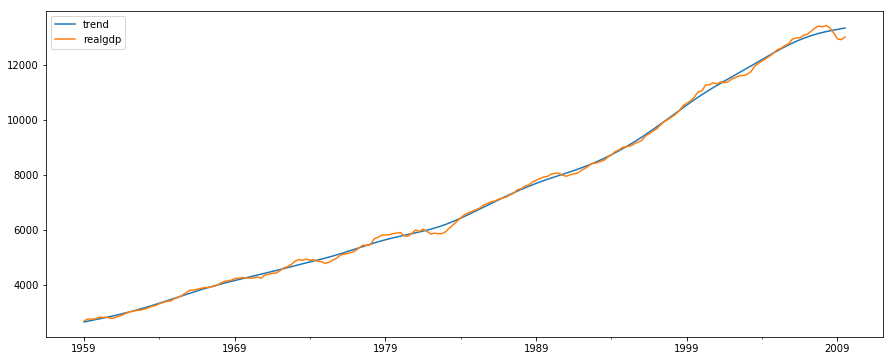

In [19]:
df[['trend','realgdp']].plot(figsize = (15,6))

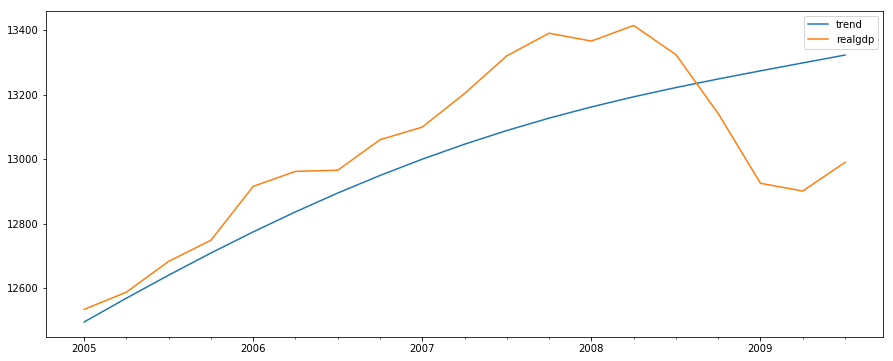

In [20]:
#zoom in 
df[['trend','realgdp']]['2005-01-01':].plot(figsize = (15,6))

## ETS Decomposition (Error Trend Seasonality)

- Apply an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. each year add 1000 passengers)
- Apply an multiplicative model when we are increasing (or decreasing) at a non-linear rate (e.g. each year double the among the passengers)

In [26]:
airline = pd.read_csv('../Data/airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [27]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [28]:
airline.isnull().sum()

Thousands of Passengers    0
dtype: int64

In [24]:
#airline.dropna(inplace = True)

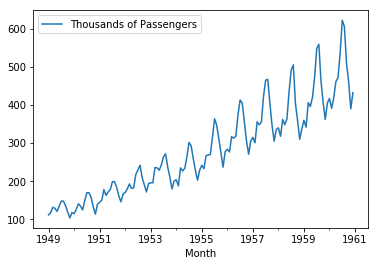

In [25]:
airline.plot()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
result = seasonal_decompose(airline['Thousands of Passengers'],model = 'multiplicative')

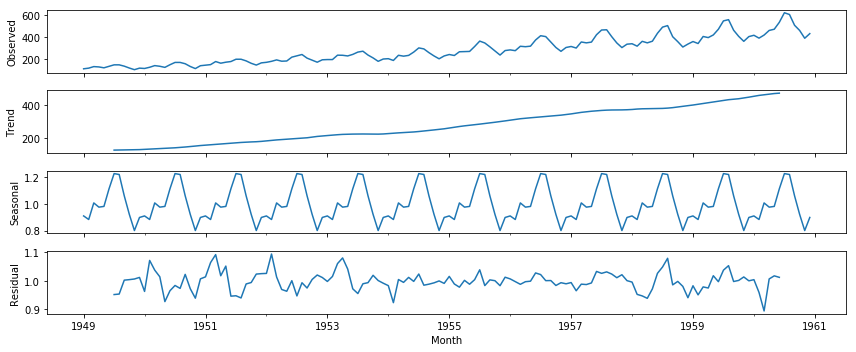

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

result.plot(); 
#Put a semi column to avoid double output

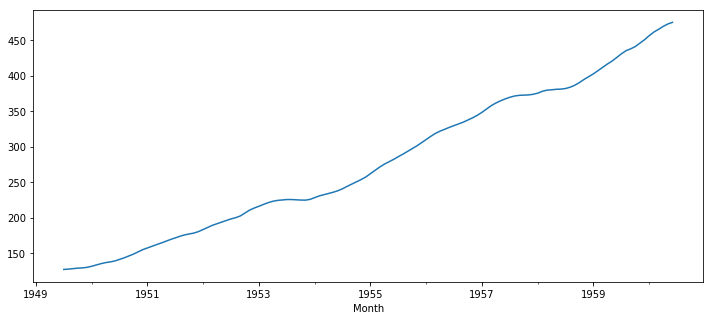

In [40]:
#PLot each individual decomposition
result.trend.plot(figsize = (12,5))

## EWMA (Exponentially weighted moving average)
- Recent points are going to be weighted more than the past points

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
airline = pd.read_csv('../Data/airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [45]:
airline.dropna(inplace = True)

In [46]:
airline.index = pd.to_datetime(airline.index)

In [47]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [48]:
airline.index #make sure the index is in datetime format

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [49]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window = 6).mean()

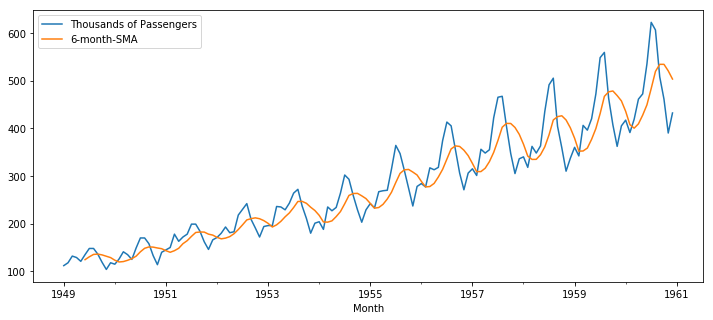

In [50]:
airline.plot()

___
# EWMA
## Exponentially Weighted Moving Average 

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

### Parameter selection

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}


* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [51]:
airline['EWMA-12'] = airline['Thousands of Passengers'].ewm(span =12).mean()

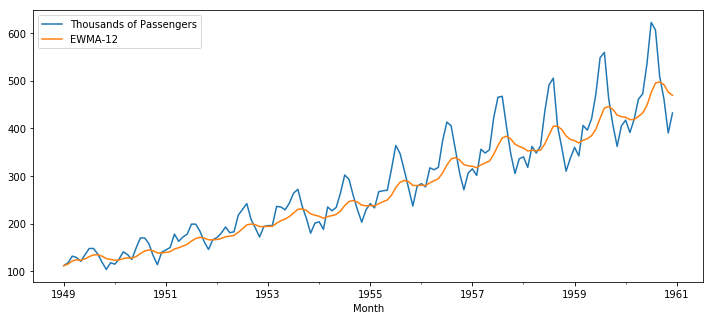

In [53]:
airline[['Thousands of Passengers','EWMA-12']].plot()
#The seasonality of the end points are more obvious than the early points

### Check out the corresponding tutorial notebook for more infomation

## Holt-Winters
- A forecase equation plus 3 smoothing methods
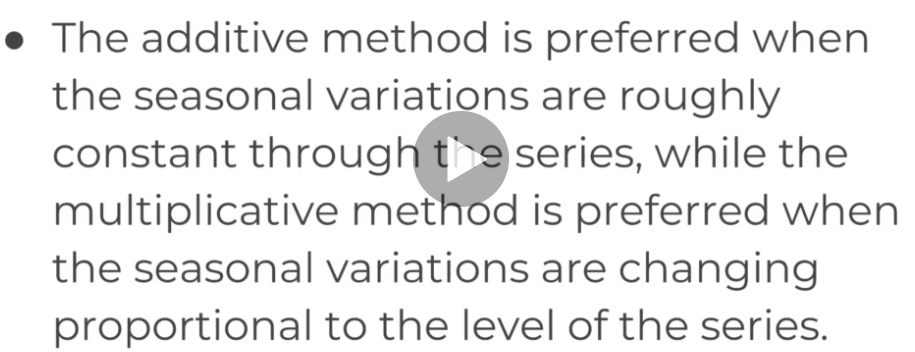 

- Double smoothing only has level and trend components
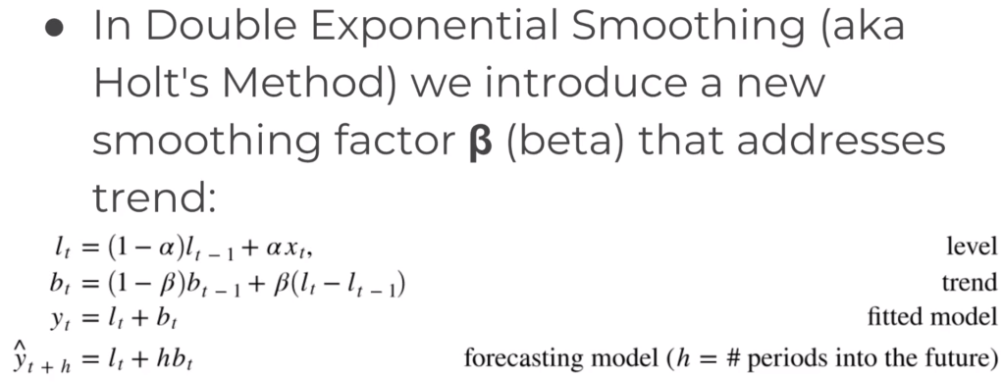

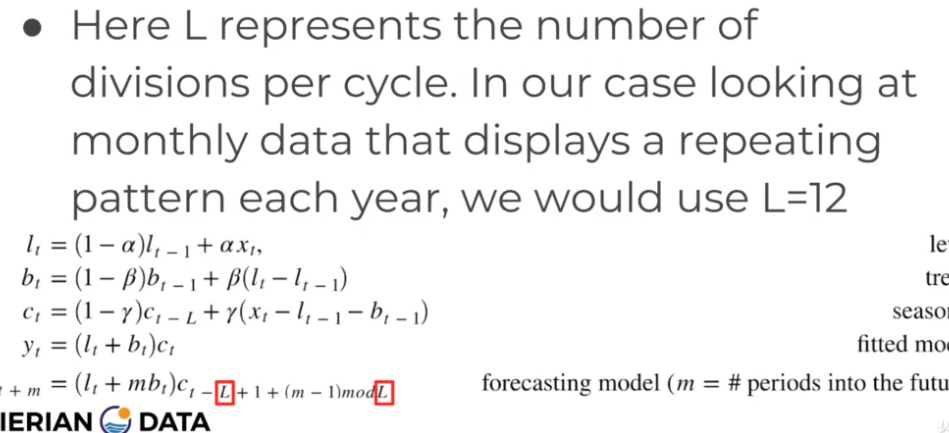
- Statsmodel will figure out these parameter values for you

## Holt Winters Methods Code Along

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col = 'Month',parse_dates = True)

In [3]:
df = df.dropna()

In [4]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [31]:
df.index.freq = 'MS' #Choose the frequence to month

In [32]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [33]:
df.head()

,Thousands of Passengers,EWMA12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.461538
1949-03-01,132,113.964497
1949-04-01,129,115.121074
1949-05-01,121,115.573299


### Simple Exp Smoothing

In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [35]:
span = 12
alpha = 2/(span+1)

In [36]:
#Get the ewma 12
df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust = False).mean()
#ewm is a method from pandas

In [37]:
df.head()

,Thousands of Passengers,EWMA12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861


##### Create ewma 12 with SimpleExpSmoothing function we just imported from Statsmodel

In [45]:
model = SimpleExpSmoothing(df['Thousands of Passengers'])

In [40]:
fitted_model = model.fit(smoothing_level = alpha, optimized = False)
#smoothing_level -> put the alpha value

In [41]:
fitted_model.fittedvalues.head()
#We found that the values has been shifted one, we need to shift it back

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    112.923077
1949-04-01    115.857988
1949-05-01    117.879836
Freq: MS, dtype: float64

In [42]:
fitted_model.fittedvalues.shift(-1).head()

Month
1949-01-01    112.000000
1949-02-01    112.923077
1949-03-01    115.857988
1949-04-01    117.879836
1949-05-01    118.359861
Freq: MS, dtype: float64

In [43]:
df['SES12'] = fitted_model.fittedvalues.shift(-1)

In [56]:
fitted_model_optimized = model.fit(smoothing_level = alpha, optimized = True)

In [60]:
df['SES12_optimized'] = fitted_model_optimized.fittedvalues.shift(-1)

In [63]:
df.tail()

,Thousands of Passengers,EWMA12,SES12,SES12_optimized
Month,,,,
1960-08-01,606,494.898619,494.898619,494.898619
1960-09-01,508,496.914216,496.914216,496.914216
1960-10-01,461,491.388952,491.388952,491.388952
1960-11-01,390,475.790652,475.790652,475.790652
1960-12-01,432,469.053629,NaN,NaN


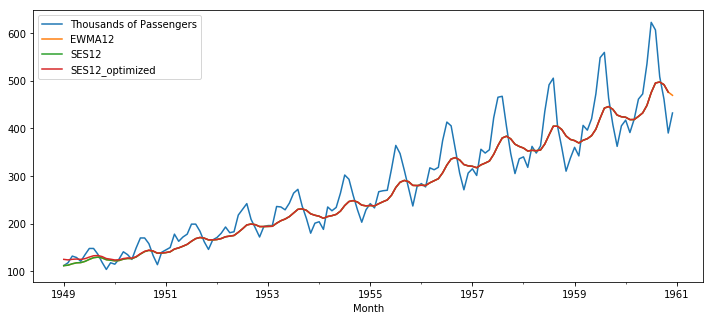

In [66]:
df.plot(figsize = [12,5]) 

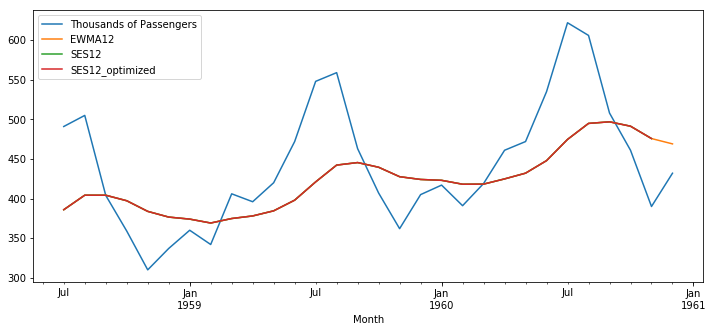

In [62]:
df.iloc[-30:].plot(figsize = [12,5]) 
#tail doesn't see a difference between optimized and not optimized

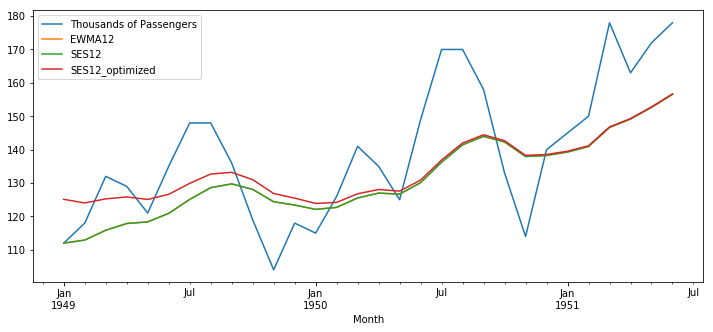

In [65]:
df.iloc[:30].plot(figsize = [12,5])
#head does see a difference between optimized and not optimized

In [ ]:
#Use one line code
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

### Double Exp Smoothing

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [82]:
df['DES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend = 'add').fit().fittedvalues.shift(-1)
#If it's linear, then use additive

In [83]:
df.head()

,Thousands of Passengers,EWMA12,SES12,SES12_optimized,DES_add_12
Month,,,,,
1949-01-01,112,112.000000,112.000000,125.126574,114.336451
1949-02-01,118,112.923077,112.923077,124.030178,120.336451
1949-03-01,132,115.857988,115.857988,125.256305,134.336451
1949-04-01,129,117.879836,117.879836,125.832258,131.336451
1949-05-01,121,118.359861,118.359861,125.088834,123.336451


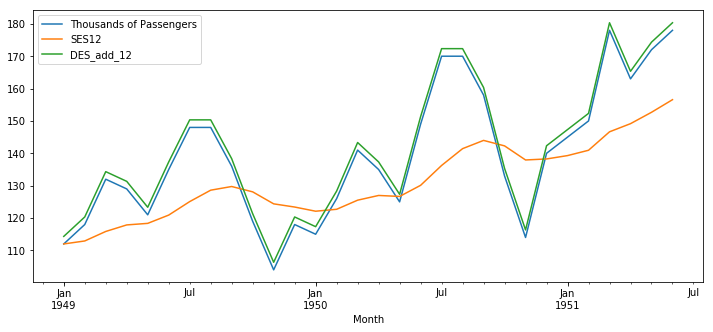

In [84]:
df[['Thousands of Passengers','SES12','DES_add_12']].iloc[:30].plot(figsize = [12,5])

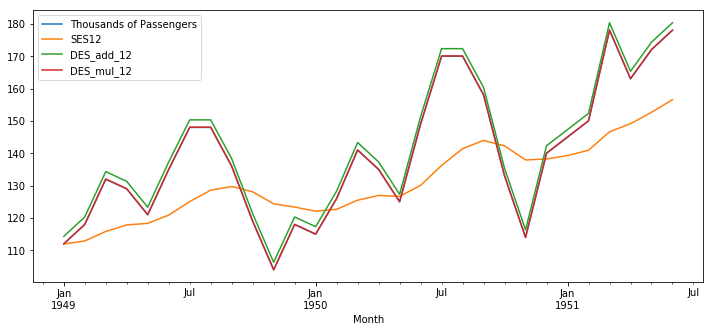

In [88]:
#No try multiplicative as trend (assume exponetial growing)
df['DES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend = 'mul').fit().fittedvalues.shift(-1)

df[['Thousands of Passengers','SES12','DES_add_12','DES_mul_12']].iloc[:30].plot(figsize = [12,5])
#Should probably use multiplicative because it fits even better

### Triple Exp Smoothing

In [90]:
#We see multiplicative works better. we use 'mul' here 
#With triple exp. We don't need to shift it back by 1
df['TES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend = 'mul',seasonal = 'mul',seasonal_periods = 12).fit().fittedvalues

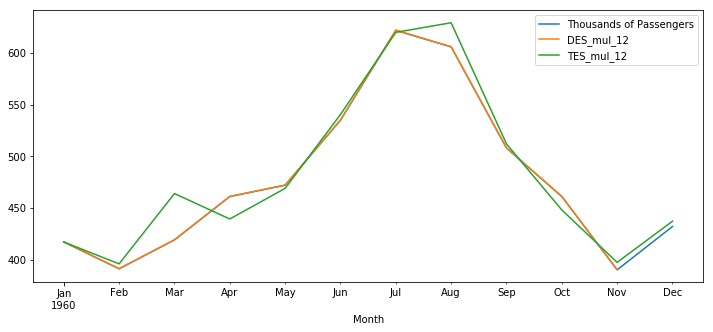

In [95]:
df[['Thousands of Passengers','DES_mul_12','TES_mul_12']].iloc[-12:].plot(figsize = [12,5])
#sees like the triple mul exp is not as good as double mul exp
#but fitting the first few years well doesn't mean good forecasting
#By adding the seasonal effects, triple exp can predict series with seasonal pattern better

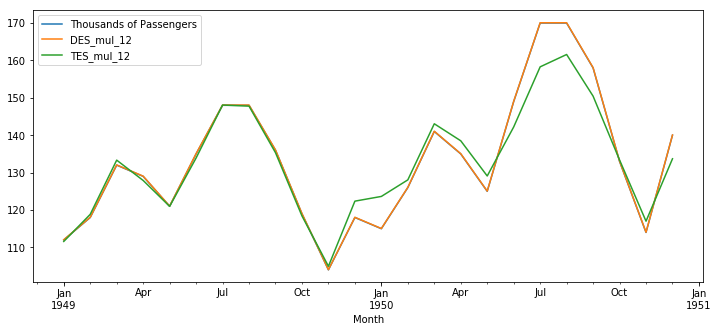

In [96]:
df[['Thousands of Passengers','DES_mul_12','TES_mul_12']].iloc[:24].plot(figsize = [12,5])
#sees like the triple mul exp is not as good as double mul exp
#but fitting the first few years well doesn't mean good forecasting
#By adding the seasonal effects, triple exp can predict series with seasonal pattern better